# paper

> This notebook contains used code that is used to generate data in the published version of the reproduce.work v0.0.1 working paper.

In [2]:
#| default_exp paper

In [9]:
#| hide
from nbdev.showdoc import *
%config InlineBackend.figure_formats = ['svg']

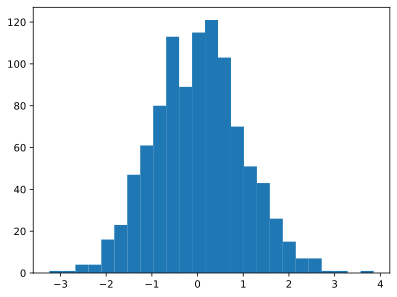

In [10]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(42)
_ = plt.hist(np.random.normal(0, 1, size=1000), bins=25)

In [13]:
#| hide
import nbdev; nbdev.nbdev_export()